# Training a model with DiscoEPG

In DiscoEPG, we provide *trainer* objects that allow the users to train a ML model with their custom dataset, namely `EPGSegment` and `EPGSegmentML`. While `EPGSegment` supports training deep learning models such as `1DCNN`, `2DCNN` or `ResNet`, `EPGSegmentML` supports `scikit-learn` traditional ML models, i.e., `XGB`, `Random Forest` and `Logistic Regression`. \
We suggest the users to use `CNN1D` with raw input or `XGB` with wavelet transform features for initial experiments thanks to their rapid training speed and competitive predicition accuracy.

In [1]:
# Autoreload utilities
%load_ext autoreload
%autoreload 2

In [2]:
# Importing trainer objects
from DiscoEPG import EPGSegment
from DiscoEPG import EPGSegmentML

## DiscoEPG
Support 1DCNN, ResNet, 2DCNN

## Training and evaluation

Each trainer will get the model settings from a config file (.json), which has to be preprocessed to a Python dictionary

In [6]:
config_file = 'C:\\Dung\\EPG_project\\ML4Insects\\configs\\cnn1d.soybeanAphid.raw.256.json'# Define the path to your config file
# Model configurations
from DiscoEPG.utils import process_config
config = process_config(config_file)
config 
# You can create/adjust the *.json configuration files in the configs folder "./DiscoEPG/configs/your_config_files.json"

{'exp_name': 'Soybean_Aphid',
 'dataset_name': 'soybeanAphid',
 'window_size': 1024,
 'hop_length': 1024,
 'arch': 'cnn1d',
 'method': 'wavelet',
 'scale': True,
 'outlier_filter': False,
 'optimizer': 'Adam',
 'n_epochs': 50,
 'lr': 0.0001,
 'batch_size': 256,
 'scope': 1,
 'data_path': 'C:\\Dung\\EPG_project\\ML4Insects\\data',
 'device': 'cuda',
 'timestamp': '2024-09-12 22:35:08'}

In [7]:
# Call the trainer
epgs = EPGSegment(config)

Training mode.
Loading data ...


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Done! Elapsed: 27.030105199999525 s


In [4]:
# Train
epgs.train(early_stop=False)

Obtaining dataloders ...
Generating sliding windows ...


100%|██████████| 32/32 [00:02<00:00, 13.26it/s]


Total: 32 recordings
Signal processing method: raw | Scale: True
Class distribution (label:ratio): 1: 0.31, 2: 0.22, 4: 0.01, 5: 0.08, 6: 0.04, 7: 0.14, 8: 0.2
Labels map (from:to): {1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6}
Train, validate, test set sizes: (72468, 28988, 11273)
Input shape: (256, 1, 1024)
Training...


Training:   2%|▏         | 1/50 [00:06<05:11,  6.36s/it]

Epoch [1/50] | Train loss: 1.0101 | Val. loss: 0.6529 | Train acc: 0.6483 | Val. acc: 0.7908


Training:  22%|██▏       | 11/50 [00:53<03:05,  4.77s/it]

Epoch [11/50] | Train loss: 0.3095 | Val. loss: 0.4211 | Train acc: 0.8996 | Val. acc: 0.8742


Training:  42%|████▏     | 21/50 [01:42<02:25,  5.02s/it]

Epoch [21/50] | Train loss: 0.2430 | Val. loss: 0.2992 | Train acc: 0.9202 | Val. acc: 0.9189


Training:  62%|██████▏   | 31/50 [02:35<01:41,  5.32s/it]

Epoch [31/50] | Train loss: 0.1992 | Val. loss: 0.2243 | Train acc: 0.9340 | Val. acc: 0.9292


Training:  82%|████████▏ | 41/50 [03:31<00:50,  5.65s/it]

Epoch [41/50] | Train loss: 0.1751 | Val. loss: 0.2229 | Train acc: 0.9423 | Val. acc: 0.9270


Training: 100%|██████████| 50/50 [04:22<00:00,  5.25s/it]

Epoch [50/50] | Train loss: 0.1475 | Val. loss: 0.1964 | Train acc: 0.9501 | Val. acc: 0.9390
Finished training!


The performance of a ML models is performed based on:
+ Task 1: Waveform classification - Accuracy and f1 scores
+ Task 2: Waveform segmentation - Overlap rate

In [5]:
# Task 1 evaluation
mean_training_loss, accuracy = epgs.evaluate('test')

Accuracy : 0.9365, Average f1: 0.8741
Class accuracy: [0.97, 0.87, 0.63, 0.96, 0.97, 0.99, 0.92]
Finished testing!


In [7]:
# Task 2 evaluation 
import os 
import numpy as np 

model_overlap_rate = []
all_test_rec = os.listdir(f'../data/Soybean.test_ANA') # replace the argument with the path to your testing directory
all_test_rec = [x[:-4] for x in all_test_rec]
for test_rec in all_test_rec:
    epgs.segment(test_rec)
    print(f'{test_rec} - Overlap rate: {epgs.overlap_rate}')
    model_overlap_rate.append(epgs.overlap_rate)
print('Done. Mean overlap rate: {:1.5f}'.format(np.mean(model_overlap_rate)))

Soybean.test_SBA-Rag5_10-6-216-ch3 - Overlap rate: 0.41001041666666665
Soybean.test_SBA-Rag5_6-10-2016-ch8 - Overlap rate: 0.856028125
Soybean.test_SBA-Rag5_6-16-2016-ch5 - Overlap rate: 0.8251555555555555
Soybean.test_SBA-Rag5_7-29-2016-ch2 - Overlap rate: 0.6550819444444445
Done. Mean overlap rate: 0.68657


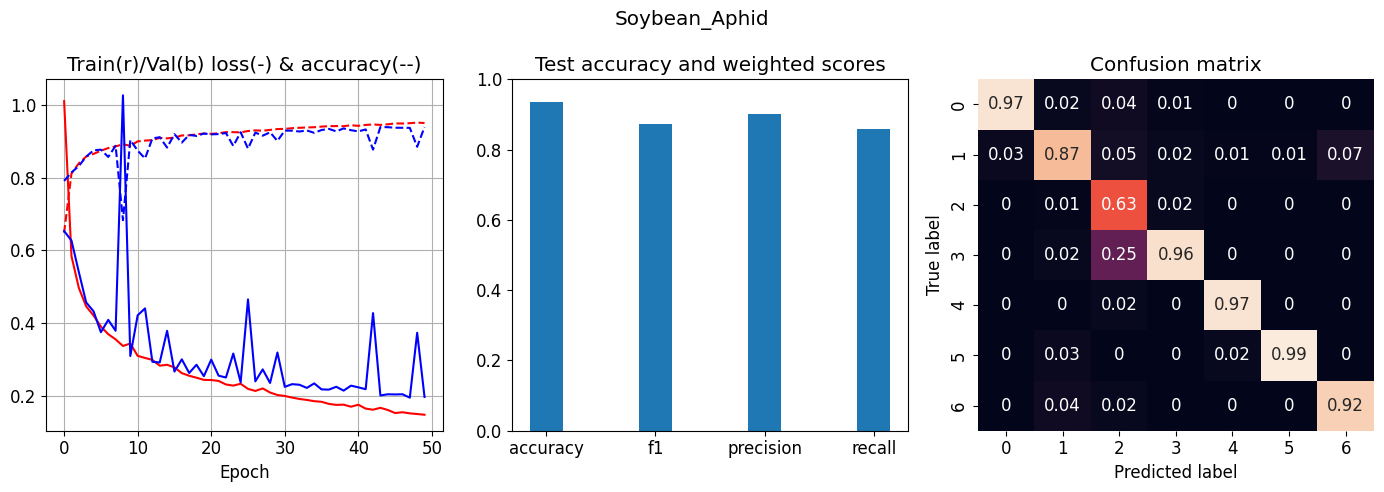

In [8]:
# We can plot the training/validation curves and task 1 results
epgs.plot_train_result()

In [14]:
# Write training log 
epgs.write_train_log()

In [9]:
# Save checkpoint
epgs.save_checkpoint(name = 'cnn1d.soybeanAphid.json')

Parameters saved to ./checkpoints/cnn1d/cnn1d.soybeanAphid.json.


## Load a pretrained model

In [12]:
# Get config
from utils.configs_utils import process_config
config = process_config('cnn1d.soybeanAphid.raw.256.json')
config 

{'exp_name': 'Soybean_Aphid',
 'dataset_name': 'soybeanAphid',
 'window_size': 1024,
 'hop_length': 1024,
 'arch': 'cnn1d',
 'method': 'raw',
 'scale': True,
 'outlier_filter': False,
 'optimizer': 'Adam',
 'n_epochs': 50,
 'lr': 0.0001,
 'batch_size': 256,
 'scope': 1,
 'data_path': '../data',
 'device': 'cuda',
 'timestamp': '2024-08-09 19:50:12'}

In [18]:
epgs = EPGSegment(config, inference = False)
# load a trained model
cp = 'cnn1d.soybeanAphid.json'
epgs.load_checkpoint(cp)

Inference mode, skip loading data.
Checkpoint loaded.


In [19]:
# predict 
pred_ana = epgs.segment(recording_name='Soybean.test_SBA-Rag5_10-6-216-ch3')

Overlap rate: 0.41001041666666665


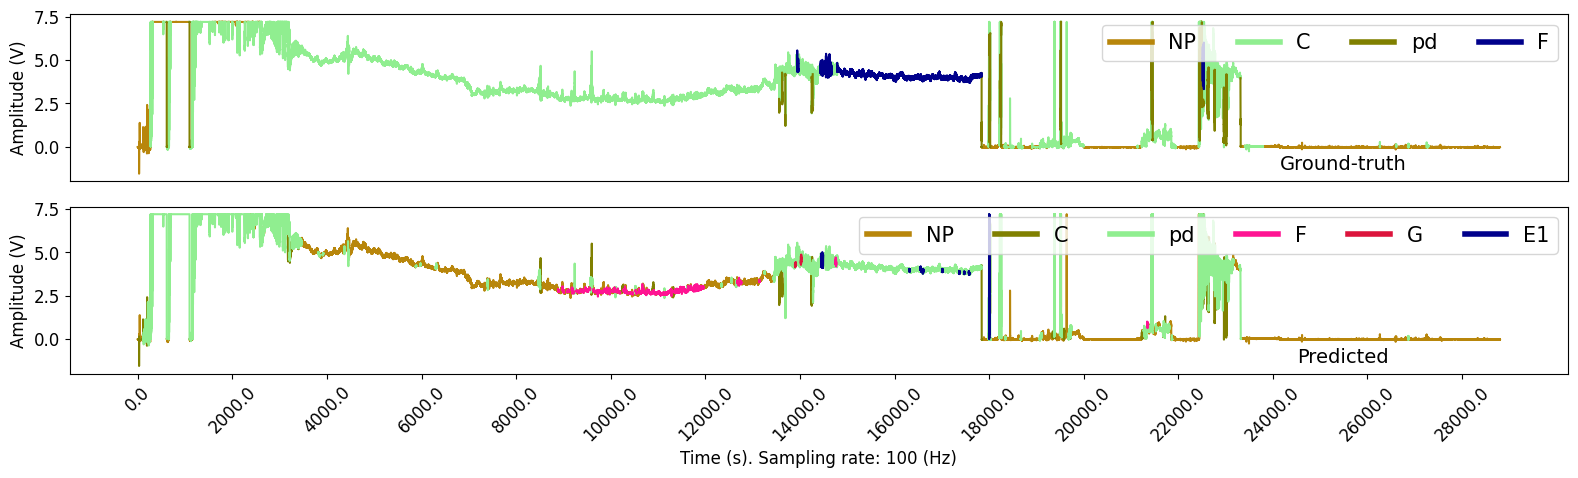

In [20]:
# plot 
print('Overlap rate:',epgs.overlap_rate)
epgs.plot_segmentation(which = 'pred_vs_gt', savefig = False, name = 'Soybean.test_SBA-Rag5_10-6-216-ch3')

In [41]:
# save analysis file 
epgs.save_analysis()

Analysis saved to ./prediction/ANA/Untitled_3.ANA


# EPGSegmentML

Support XGB, RF, LogReg, SVC

In [14]:
# Get config
from utils.configs_utils import process_config

config = process_config('XGB.soybeanAphid.wavelet.json')
config 

{'exp_name': 'Soybean_Aphid',
 'dataset_name': 'soybeanAphid',
 'window_size': 1024,
 'hop_length': 1024,
 'arch': 'XGB',
 'method': 'wavelet',
 'scale': True,
 'outlier_filter': False,
 'n_epochs': 100,
 'scope': 1,
 'data_path': '../data',
 'device': 'cpu',
 'timestamp': '2024-08-09 14:38:08'}

In [18]:
from dataset_utils.MLdatagenerator import read_dataset_from_config
from models.SegmentationML import EPGSegmentML

In [19]:
# Call the trainer
epg = EPGSegmentML(config)

Loading data ...


100%|██████████| 32/32 [00:24<00:00,  1.29it/s]

Done! Elapsed: 24.881079100014176 s


In [39]:
# Generate training data
# Feature calculation may takes a long time (About 10 minutes for 32 recordings)
# After that, the features matrix will be saved so that you will not have to calculate it again
epg.get_traindata()

Generating sliding windows ...


100%|██████████| 32/32 [00:02<00:00, 13.18it/s]


Total: 32 recordings
Signal processing method: raw | Scale: True
Class distribution (label:ratio): 1: 0.31, 2: 0.22, 4: 0.01, 5: 0.08, 6: 0.04, 7: 0.14, 8: 0.2
Labels map (from:to): {1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6}
Computing training features matrices ...


100%|██████████| 90183/90183 [09:12<00:00, 163.19it/s]


Computing testing features matrices ...


100%|██████████| 22546/22546 [02:19<00:00, 161.99it/s]


Dataset soybeanAphid. Elapsed computation time: 692.8006565000396
Saving datasets to .csv ...


FileNotFoundError: [Errno 2] No such file or directory: '../data/log/features_computation_time.txt'

In [41]:
# Read the training datasets
import pandas as pd

def read_dataset_csv(dataset_name, data_path = '../data/dataML'):
    columns = []
    for i in range(4):
        columns += [f'n5_{i}', f'n25_{i}', f'n75_{i}', f'n95_{i}', f'median_{i}', 
                    f'mean_{i}', f'std_{i}', f'var_{i}', f'rms_{i}', f'sk_{i}', f'zcr_{i}', f'en_{i}', f'perm_en_{i}']
    X_train = pd.read_csv(f'{data_path}/Data_{dataset_name}_train.csv',header = None)
    X_test = pd.read_csv(f'{data_path}/Data_{dataset_name}_test.csv',header = None)
    y_train =  pd.read_csv(f'{data_path}/Label_{dataset_name}_train.csv',header = None)
    y_test =  pd.read_csv(f'{data_path}/Label_{dataset_name}_test.csv',header = None)
    
    X_train.columns = columns
    X_test.columns = columns
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = read_dataset_csv(config['dataset_name'])

In [42]:
# Training
epg.fit(X_train, y_train)

Training...
Finished training. Elapsed time: 20.741 (s)


In [43]:
# Task 1 evaluation
pred = epg.predict(X_test, y_test)

Predicting ...
Accuracy: 0.9525, f1: 0.9165
Finished testing.


In [47]:
# Task 2 evaluation (segmentation)
pred_ana = epg.segment('Soybean.test_SBA-Rag5_6-10-2016-ch8')
epg.save_analysis()

Generating segmentation ...


100%|██████████| 2812/2812 [00:17<00:00, 158.15it/s]


Overlapping rate: 0.8964878472222222


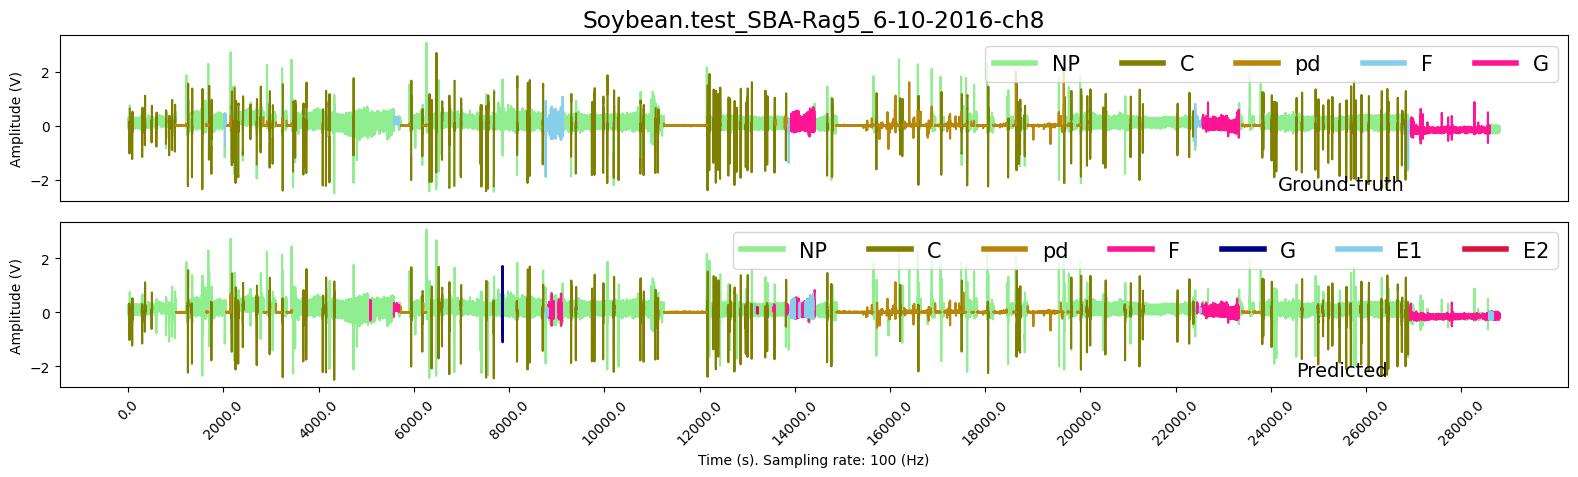

In [48]:
epg.plot_segmentation(which = 'pred_vs_gt')